<a href="https://colab.research.google.com/github/DhruvDhariwal/PyTorch-MNIST/blob/main/Pytorch_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [8]:
torch.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
train_data=datasets.MNIST(
    root='data',
    download=True,
    train=True,
    transform=ToTensor()
)

test_data=datasets.MNIST(
    root='data',
    download=True,
    train=False,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.64MB/s]


In [10]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [11]:
image,label = train_data[0]
image.shape, label
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

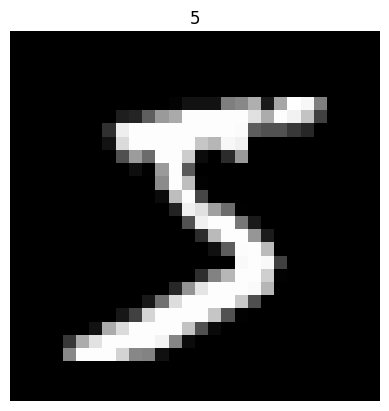

In [12]:
plt.imshow(image.squeeze(dim=0), cmap='gray')
plt.title(label)
plt.axis(False)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

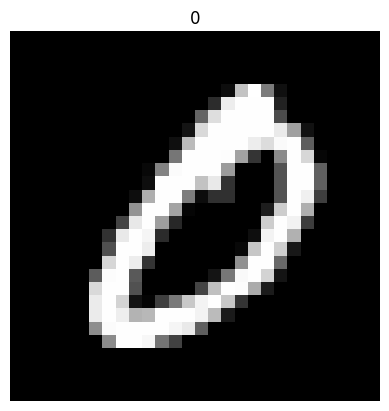

In [13]:
random_index = torch.randint(0, len(train_data), size=(1,)).item()
image,label=train_data[random_index]
plt.imshow(image.squeeze(dim=0), cmap='gray')
plt.title(label)
plt.axis(False)

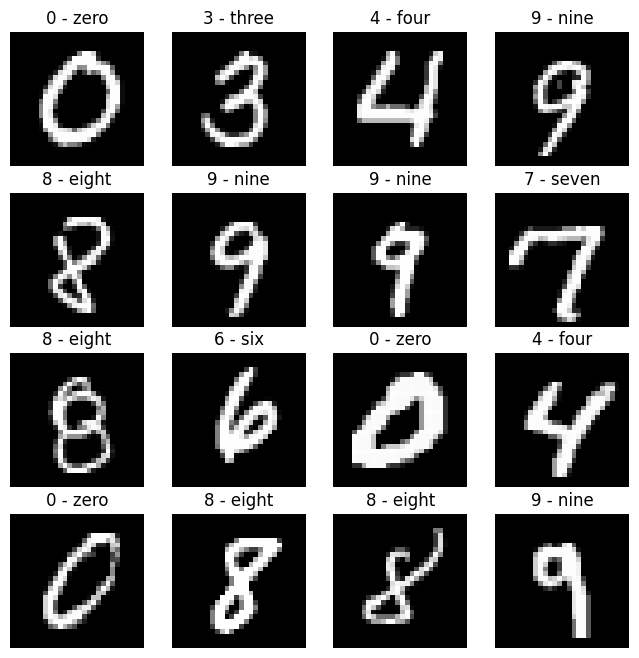

In [14]:
fig=plt.figure(figsize=(8,8))
rows,cols=4,4
for i in range(1, rows*cols+1):
    random_index = torch.randint(0, len(train_data), size=(1,)).item()
    image,label=train_data[random_index]
    fig.add_subplot(rows,cols,i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [15]:
class MNISTModel0(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        self.block2=nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
        ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
            )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)

        )

    def forward(self,x:torch.Tensor) -> torch.tensor:
            return self.classifier(self.block2(self.block1(x)))

In [16]:
model0 = MNISTModel0(input_shape=1,hidden_units=10,output_shape=10).to(device)
model0

MNISTModel0(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [18]:
train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

In [19]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [20]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch {epoch+1} -------')
    train_loss = 0
    model0.to(device)
    model0.train()
    for X,y in train_dataloader:
        X,y = X.to(device), y.to(device)
        y_pred = model0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    train_loss /= len(train_dataloader)
    print(f'Train loss: {train_loss:.5f}')
    model0.to(device)
    model0.eval()
    with torch.inference_mode():
        test_loss, test_acc = 0,0
        for X,y in test_dataloader:
            X,y = X.to(device), y.to(device)
            test_pred = model0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f'Test loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 -------
Train loss: 0.45412
Test loss: 0.08904 | Test Accuracy: 97.23
Epoch 2 -------
Train loss: 0.08349
Test loss: 0.05600 | Test Accuracy: 98.05
Epoch 3 -------
Train loss: 0.06473
Test loss: 0.05596 | Test Accuracy: 98.10


In [21]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/157 [00:00<?, ?it/s]

In [22]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [23]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


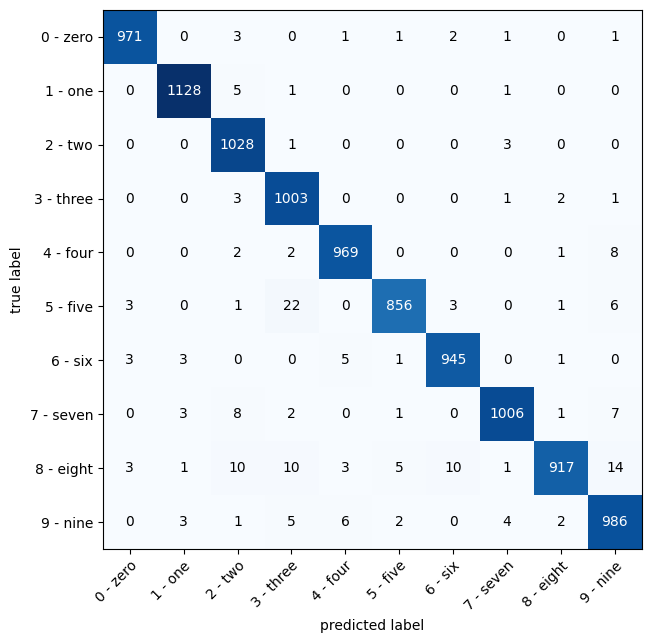

In [24]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [27]:
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

for images, labels in test_loader:
    outputs = model0(images)
    predicted = torch.max(outputs.data, 1)[1]
    if predicted != labels:
        misclassified_images.append(images.squeeze().numpy())
        misclassified_true_labels.append(labels.item())
        misclassified_pred_labels.append(predicted.item())

def imshow(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

print(f'Total misclassified images: {len(misclassified_images)}')
for idx in range(len(misclassified_images)):
    print(f'True Label: {misclassified_true_labels[idx]}, Predicted: {misclassified_pred_labels[idx]}')
    imshow(misclassified_images[idx])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [28]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "MNIST_Model0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/MNIST_Model0.pth


In [29]:
import nbformat

def deep_clean_widgets_metadata(filepath):
    with open(filepath, encoding="utf-8") as f:
        nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

    # Clean each cell's metadata
    for cell in nb.cells:
        if 'metadata' in cell and 'widgets' in cell['metadata']:
            print("🧹 Removing widget metadata from a cell")
            del cell['metadata']['widgets']

    # Clean notebook-level metadata
    if 'widgets' in nb['metadata']:
        print("🧹 Removing notebook-level widget metadata")
        del nb['metadata']['widgets']

    # Save the cleaned notebook
    with open(filepath, "w", encoding="utf-8") as f:
        nbformat.write(nb, f)

    print(f"✅ Fully cleaned: {filepath}")

# 🔁 REPLACE with your actual path if needed
deep_clean_widgets_metadata("/content/drive/MyDrive/Colab Notebooks/Pytorch MNIST.ipynb")


✅ Fully cleaned: /content/drive/MyDrive/Colab Notebooks/Pytorch MNIST.ipynb
